## **Proyek Pertama: Sentiment Analisys**



> Nama : Muhammad Faqih Hakim



install sastrawi terlebih dahulu karena teks yang akan kita olah berbahasa indonesia

In [1]:
!pip install Sastrawi

## **import library yang dibutuhkan**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import re
import csv
import requests
import nltk
import string
from nltk import punkt
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from io import StringIO
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from keras.preprocessing.sequence import pad_sequences
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# **Loading Dataset**

In [3]:
review_df = pd.read_csv('./ReviewTokopedia.csv')
review_df

,Review
0,Saya pelanggan baru. Awalnya sebagai pelanggan...
1,Pesanan ilang ga tau kemana pelayanan komplain...
2,Saya pengguna lama tokopedia... Kurir rekomend...
3,"Make ini dah lama, sayangnya selalu ada kendal..."
4,sangat puas dengan tokopedia. sangat komplit n...
...,...
10095,Keren banget program gratis ongkir minimal bel...
10096,"Makin kacau aja perasaan ni, masa sekarang kal..."
10097,saya sebagai pengguna lama . sekarang kecewa b...
10098,kenapa toko pedia langsung menghentikan loadin...


Cek apakah terdapat Null didalam dataset

In [4]:
review_df.isna().sum()

Review    0
dtype: int64

Cek duplikasi

In [5]:
review_df.duplicated().sum()
df = review_df

Cek Informasi

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10100 entries, 0 to 10099
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  10100 non-null  object
dtypes: object(1)
memory usage: 79.0+ KB


## **Preprocessing Teks**

besihkan teks yang mengandung mention, hastag, retweet, tautan, serta tanda baca, lalu ubah semuanya menjadi lowercase agar seragam, dll.

In [7]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = re.sub(r'RT[\s]', '', text)
    text = re.sub(r"http\S+", '', text)
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.replace('\n', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip(' ')
    return text

def casefoldingText(text):
    return text.lower()

def tokenizingText(text):
    return word_tokenize(text)

def filteringText(text):
    listStopwords = set(stopwords.words('indonesian')).union(set(stopwords.words('english')))
    additional_stopwords = ['eh', 'c', 'g','nge','ko', 'deh', 'iya', 'yaa', 'gak', 'nya', 'na', 'sih', 'ku', 'di', 'ga', 'ya', 'gaa', 'loh', 'kah', 'woi', 'woii', 'woy', 'tuh', 'si', 'vt', 'gw', 'fyp']
    listStopwords.update(additional_stopwords)
    return [word for word in text if word not in listStopwords]

def stemmingText(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    return ' '.join([stemmer.stem(word) for word in text])

def toSentence(list_words):
    sentence = ' '.join(word for word in list_words)
    return sentence

Buat fungsi untuk memperbaiki kalimat slang dan juga menghapus emoji

In [8]:
def fix_slangwords(text):
    slangwords = {
        "abis": "habis", "bgt": "sekali", "gak": "tidak", "krn": "karena",
        "kalo": "kalau", "maen": "main", "pake": "pakai", "trs": "terus", "tp": "tapi",
        "sbg": "sebagai", "blm": "belum", "sy": "saya", "dr": "dari", "dg": "dengan",
        "dl": "dulu", "sm": "sama", "spt": "seperti", "kmrn": "kemarin", "dpt": "dapat",
        "tdk": "tidak", "trnyata": "ternyata", "udh": "sudah", "prnh": "pernah",
        "mkn": "makan", "ngga": "tidak", "ntr": "nanti", "aja": "saja", "knpa": "kenapa",
        "bagu": "bagus", "dah": "sudah", "lg": "lagi", "lgs": "langsung",
        "jdi": "jadi", "jgn": "jangan", "jkt": "jakarta", "ak": "aku", "ad": "ada",
        "ny": "nya", "ilang": "hilang", "skrng": "sekarang", "mulu": "selalu",
        "gini": "seperti ini", "an": "akan", "smg": "semoga", "tsb": "tersebut",
        "bs": "bisa", "ya": "iya", "ng": "nanti", "yg": "yang", "gak": "tidak", "sdh": "sudah", "jd": "jadi",
        "trus": "terus", "skrg": "sekarang", "klo": "kalau", "aja": "saja", "km": "kamu",
        "dlm": "dalam", "org": "orang", "hrs": "harus", "bbrp": "beberapa", "gt": "gitu",
        "bkn": "bukan", "sbg": "sebagai", "mrk": "mereka", "msh": "masih", "sh": "sih",
        "dgn": "dengan", "td": "tadi", "mlm": "malam", "utk": "untuk", "syg": "sayang",
        "kpd": "kepada", "blg": "bilang", "ttp": "tetap", "pdhl": "padahal", "krn": "karena",
        "sbnrnya": "sebenarnya", "knp": "kenapa", "mn": "mana", "jg": "juga", "pls": "please",
        "mnrut": "menurut", "bs": "bisa", "kl": "kalau", "yg": "yang", "sbg": "sebagai",
        "nggak": "tidak", "pokoknya": "pokok", "plg": "paling", "ngg": "tidak", "aku": "saya"
    }
    words = text.split()
    fixed_words = [slangwords[word.lower()] if word.lower() in slangwords else word for word in words]
    return ' '.join(fixed_words)

def remove_emojis(text):
    emote = re.compile(
        "["u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F700-\U0001F77F"
        u"\U0001F780-\U0001F7FF"
        u"\U0001F800-\U0001F8FF"
        u"\U0001F900-\U0001F9FF"
        u"\U0001FA00-\U0001FA6F"
        u"\U0001FA70-\U0001FAFF"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    return emote.sub(r'', text)


gunakan fungsi yang sebelumnya dibuat untuk preprocessing teks ke dalam dataframe

In [9]:
df['text_clean'] = df['Review'].apply(cleaningText)
df['text_casefoldingText'] = df['text_clean'].apply(casefoldingText)
df['text_slangwords'] = df['text_casefoldingText'].apply(fix_slangwords)
df['text_tokenizingText'] = df['text_slangwords'].apply(tokenizingText)
df['text_stopword'] = df['text_tokenizingText'].apply(filteringText)
df['text_akhir'] = df['text_stopword'].apply(toSentence)

menampilkan perubahan

In [10]:
df

,Review,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir
0,Saya pelanggan baru. Awalnya sebagai pelanggan...,Saya pelanggan baru Awalnya sebagai pelanggan ...,saya pelanggan baru awalnya sebagai pelanggan ...,saya pelanggan baru awalnya sebagai pelanggan ...,"[saya, pelanggan, baru, awalnya, sebagai, pela...","[pelanggan, pelanggan, promo, hemat, menggiurk...",pelanggan pelanggan promo hemat menggiurkan ba...
1,Pesanan ilang ga tau kemana pelayanan komplain...,Pesanan ilang ga tau kemana pelayanan komplain...,pesanan ilang ga tau kemana pelayanan komplain...,pesanan hilang ga tau kemana pelayanan komplai...,"[pesanan, hilang, ga, tau, kemana, pelayanan, ...","[pesanan, hilang, tau, kemana, pelayanan, komp...",pesanan hilang tau kemana pelayanan komplain l...
2,Saya pengguna lama tokopedia... Kurir rekomend...,Saya pengguna lama tokopedia Kurir rekomendasi...,saya pengguna lama tokopedia kurir rekomendasi...,saya pengguna lama tokopedia kurir rekomendasi...,"[saya, pengguna, lama, tokopedia, kurir, rekom...","[pengguna, tokopedia, kurir, rekomendasi, id, ...",pengguna tokopedia kurir rekomendasi id expres...
3,"Make ini dah lama, sayangnya selalu ada kendal...",Make ini dah lama sayangnya selalu ada kendala...,make ini dah lama sayangnya selalu ada kendala...,make ini sudah lama sayangnya selalu ada kenda...,"[make, ini, sudah, lama, sayangnya, selalu, ad...","[make, sayangnya, kendala, kurir, cepat, pick,...",make sayangnya kendala kurir cepat pick paket ...
4,sangat puas dengan tokopedia. sangat komplit n...,sangat puas dengan tokopedia sangat komplit nj...,sangat puas dengan tokopedia sangat komplit nj...,sangat puas dengan tokopedia sangat komplit nj...,"[sangat, puas, dengan, tokopedia, sangat, komp...","[puas, tokopedia, komplit, njerit, kayak, toko...",puas tokopedia komplit njerit kayak toko perta...
...,...,...,...,...,...,...,...
10095,Keren banget program gratis ongkir minimal bel...,Keren banget program gratis ongkir minimal bel...,keren banget program gratis ongkir minimal bel...,keren banget program gratis ongkir minimal bel...,"[keren, banget, program, gratis, ongkir, minim...","[keren, banget, program, gratis, ongkir, minim...",keren banget program gratis ongkir minimal bel...
10096,"Makin kacau aja perasaan ni, masa sekarang kal...",Makin kacau aja perasaan ni masa sekarang kalo...,makin kacau aja perasaan ni masa sekarang kalo...,makin kacau saja perasaan ni masa sekarang kal...,"[makin, kacau, saja, perasaan, ni, masa, sekar...","[kacau, perasaan, ni, pakai, gratis, ongkir, d...",kacau perasaan ni pakai gratis ongkir dapet po...
10097,saya sebagai pengguna lama . sekarang kecewa b...,saya sebagai pengguna lama sekarang kecewa bg...,saya sebagai pengguna lama sekarang kecewa bg...,saya sebagai pengguna lama sekarang kecewa sek...,"[saya, sebagai, pengguna, lama, sekarang, kece...","[pengguna, kecewa, barang, udah, minggu, sampa...",pengguna kecewa barang udah minggu sampai² eks...
10098,kenapa toko pedia langsung menghentikan loadin...,kenapa toko pedia langsung menghentikan loadin...,kenapa toko pedia langsung menghentikan loadin...,kenapa toko pedia langsung menghentikan loadin...,"[kenapa, toko, pedia, langsung, menghentikan, ...","[toko, pedia, langsung, menghentikan, loading,...",toko pedia langsung menghentikan loading muncu...


## **Pelabelan**

memberikan label kategori untuk setiap data

In [11]:
lexicon_positive = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')
    for row in reader:
        lexicon_positive[row[0]] = int(row[1])
else:
    print("Failed to fetch positive lexicon data")

lexicon_negative = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')

if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')
    for row in reader:
        lexicon_negative[row[0]] = int(row[1])
else:
    print("Failed to fetch negative lexicon data")

analisis sentimen pada teks menggunakan kamus positif dan negatif serta netral

In [12]:
def sentiment_analysis_lexicon_indonesia(text):
    score = 0
    for word in text:
        if word in lexicon_positive:
            score += lexicon_positive[word]
        elif word in lexicon_negative:
            score += lexicon_negative[word]

    polarity = ''
    if score > 0:
        polarity = 'positive'
    elif score < 0:
        polarity = 'negative'
    else:
        polarity = 'neutral'

    return score, polarity

terapkan fungsi sebelumnya kedalam dataset

In [13]:
results = df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
scores, polarities = list(zip(*results))
df['polarity_score'] = scores
df['polarity'] = polarities
print(df['polarity'].value_counts())
df

polarity
positive    6800
negative    2841
neutral      459
Name: count, dtype: int64


,Review,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir,polarity_score,polarity
0,Saya pelanggan baru. Awalnya sebagai pelanggan...,Saya pelanggan baru Awalnya sebagai pelanggan ...,saya pelanggan baru awalnya sebagai pelanggan ...,saya pelanggan baru awalnya sebagai pelanggan ...,"[saya, pelanggan, baru, awalnya, sebagai, pela...","[pelanggan, pelanggan, promo, hemat, menggiurk...",pelanggan pelanggan promo hemat menggiurkan ba...,36,positive
1,Pesanan ilang ga tau kemana pelayanan komplain...,Pesanan ilang ga tau kemana pelayanan komplain...,pesanan ilang ga tau kemana pelayanan komplain...,pesanan hilang ga tau kemana pelayanan komplai...,"[pesanan, hilang, ga, tau, kemana, pelayanan, ...","[pesanan, hilang, tau, kemana, pelayanan, komp...",pesanan hilang tau kemana pelayanan komplain l...,24,positive
2,Saya pengguna lama tokopedia... Kurir rekomend...,Saya pengguna lama tokopedia Kurir rekomendasi...,saya pengguna lama tokopedia kurir rekomendasi...,saya pengguna lama tokopedia kurir rekomendasi...,"[saya, pengguna, lama, tokopedia, kurir, rekom...","[pengguna, tokopedia, kurir, rekomendasi, id, ...",pengguna tokopedia kurir rekomendasi id expres...,21,positive
3,"Make ini dah lama, sayangnya selalu ada kendal...",Make ini dah lama sayangnya selalu ada kendala...,make ini dah lama sayangnya selalu ada kendala...,make ini sudah lama sayangnya selalu ada kenda...,"[make, ini, sudah, lama, sayangnya, selalu, ad...","[make, sayangnya, kendala, kurir, cepat, pick,...",make sayangnya kendala kurir cepat pick paket ...,14,positive
4,sangat puas dengan tokopedia. sangat komplit n...,sangat puas dengan tokopedia sangat komplit nj...,sangat puas dengan tokopedia sangat komplit nj...,sangat puas dengan tokopedia sangat komplit nj...,"[sangat, puas, dengan, tokopedia, sangat, komp...","[puas, tokopedia, komplit, njerit, kayak, toko...",puas tokopedia komplit njerit kayak toko perta...,3,positive
...,...,...,...,...,...,...,...,...,...
10095,Keren banget program gratis ongkir minimal bel...,Keren banget program gratis ongkir minimal bel...,keren banget program gratis ongkir minimal bel...,keren banget program gratis ongkir minimal bel...,"[keren, banget, program, gratis, ongkir, minim...","[keren, banget, program, gratis, ongkir, minim...",keren banget program gratis ongkir minimal bel...,17,positive
10096,"Makin kacau aja perasaan ni, masa sekarang kal...",Makin kacau aja perasaan ni masa sekarang kalo...,makin kacau aja perasaan ni masa sekarang kalo...,makin kacau saja perasaan ni masa sekarang kal...,"[makin, kacau, saja, perasaan, ni, masa, sekar...","[kacau, perasaan, ni, pakai, gratis, ongkir, d...",kacau perasaan ni pakai gratis ongkir dapet po...,14,positive
10097,saya sebagai pengguna lama . sekarang kecewa b...,saya sebagai pengguna lama sekarang kecewa bg...,saya sebagai pengguna lama sekarang kecewa bg...,saya sebagai pengguna lama sekarang kecewa sek...,"[saya, sebagai, pengguna, lama, sekarang, kece...","[pengguna, kecewa, barang, udah, minggu, sampa...",pengguna kecewa barang udah minggu sampai² eks...,-4,negative
10098,kenapa toko pedia langsung menghentikan loadin...,kenapa toko pedia langsung menghentikan loadin...,kenapa toko pedia langsung menghentikan loadin...,kenapa toko pedia langsung menghentikan loadin...,"[kenapa, toko, pedia, langsung, menghentikan, ...","[toko, pedia, langsung, menghentikan, loading,...",toko pedia langsung menghentikan loading muncu...,3,positive


Visualisasi Data polarisasi

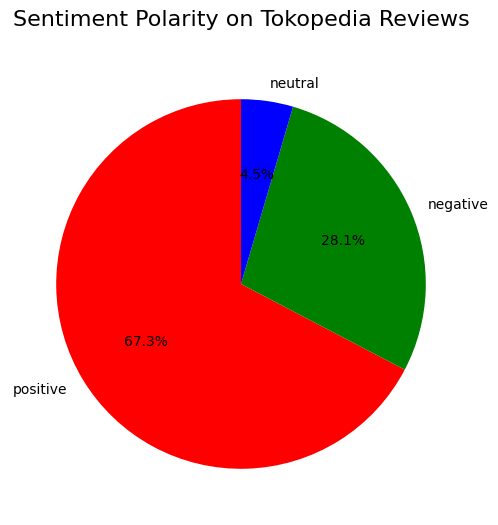

In [14]:
sizes = df['polarity'].value_counts()
labels = sizes.index

fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['red', 'green', 'blue'])
ax.set_title('Sentiment Polarity on Tokopedia Reviews', fontsize=16, pad=20)

plt.show()

## **Eksplorasi Label**


berikut merupakan kata kata yang sering muncul dalam review aplikasi tokopedia


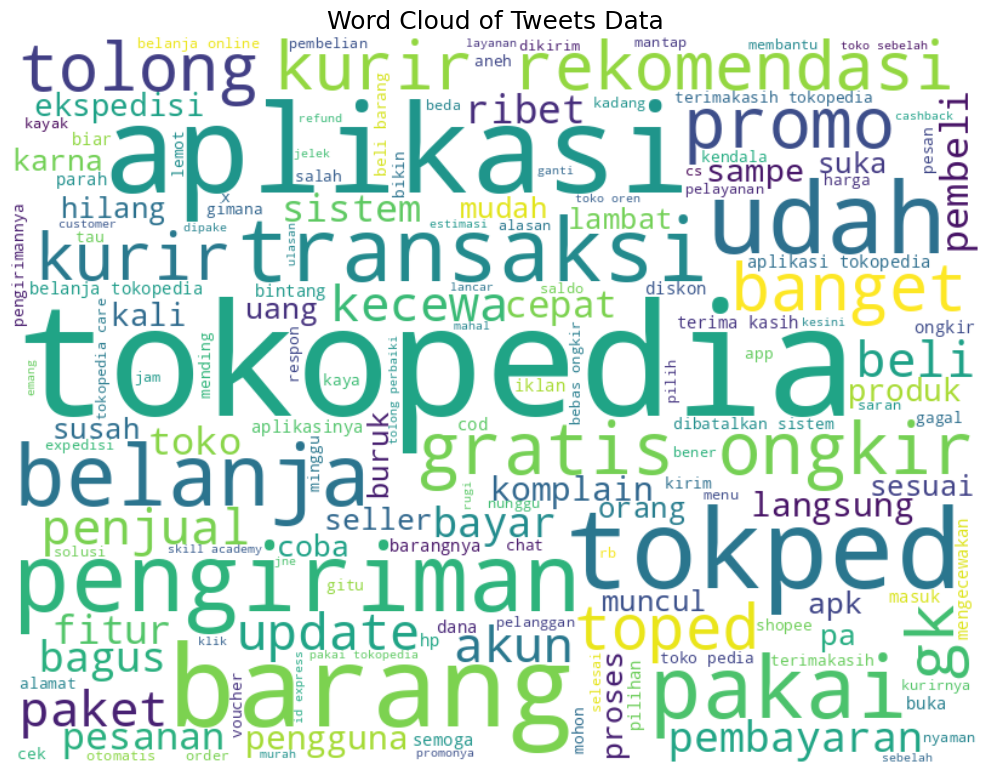

In [15]:
list_words = ' '.join(df['text_stopword'].apply(lambda x: ' '.join(x)))

wordcloud = WordCloud(width=800, height=600, background_color='white', min_font_size=10).generate(list_words)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Tweets Data', fontsize=18)
plt.axis('off')
plt.tight_layout()

plt.show()

berikut merupakan kata kata yang sering muncul dalam review **positive** aplikasi tokopedia

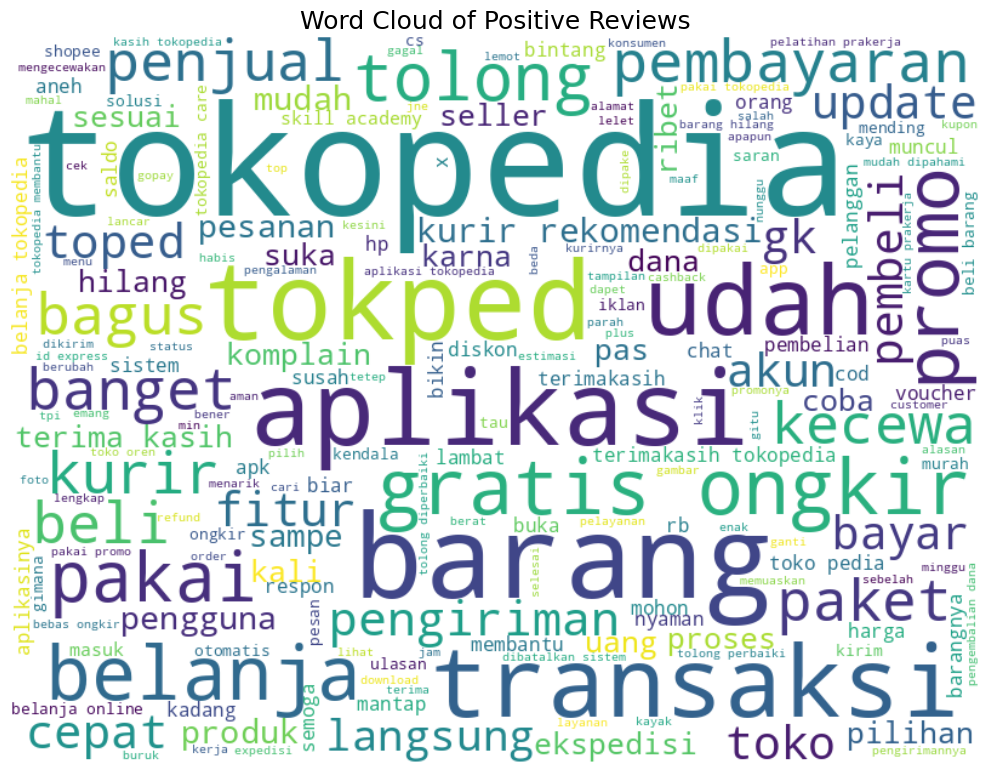

In [16]:
positive_tweets = df[df['polarity'] == 'positive']
positive_tweets = positive_tweets[['text_akhir', 'polarity_score', 'polarity','text_stopword']]

positive_tweets = positive_tweets.sort_values(by='polarity_score', ascending=False)
positive_tweets = positive_tweets.reset_index(drop=True)

list_words_positive = ' '.join(positive_tweets['text_stopword'].apply(lambda x: ' '.join(x)))
wordcloud_positive = WordCloud(width=800, height=600, background_color='white', min_font_size=10).generate(list_words_positive)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Word Cloud of Positive Reviews', fontsize=18)
plt.axis('off')
plt.tight_layout()

plt.show()


berikut merupakan kata kata yang sering muncul dalam review **Netral** aplikasi tokopedia

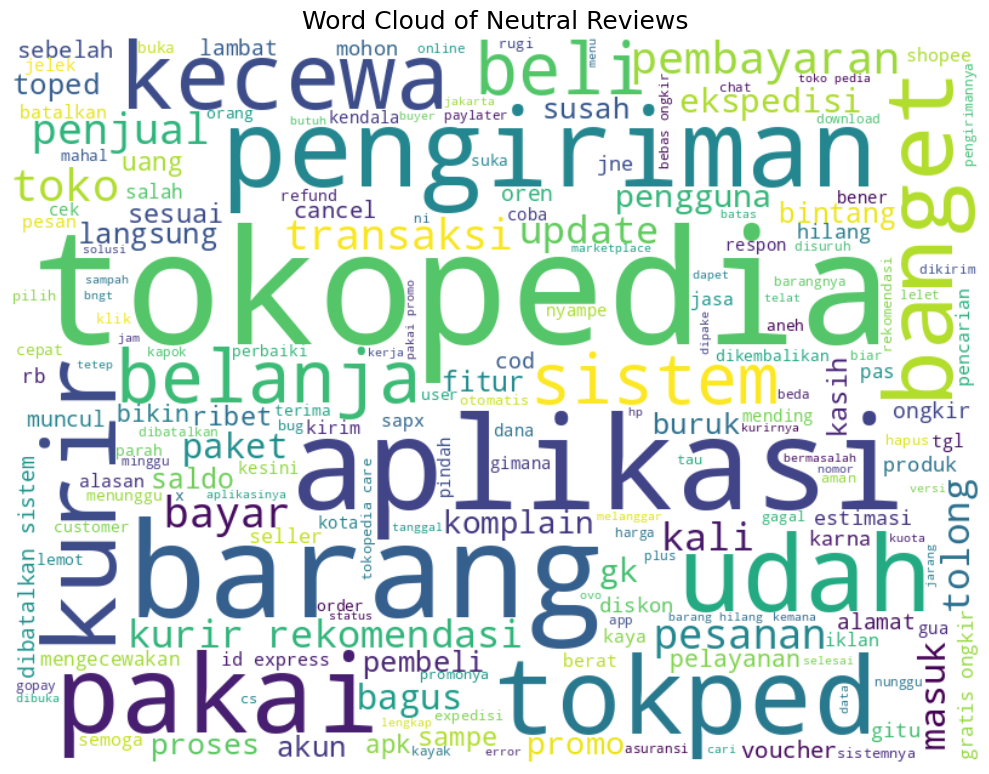

In [17]:
neutral_tweets = df[df['polarity'] == 'neutral']
neutral_tweets = neutral_tweets[['text_akhir', 'polarity_score', 'polarity', 'text_stopword']]

neutral_tweets = neutral_tweets.sort_values(by='polarity_score', ascending=False)
neutral_tweets = neutral_tweets.reset_index(drop=True)

list_words_neutral = ' '.join(neutral_tweets['text_stopword'].apply(lambda x: ' '.join(x)))
wordcloud_neutral = WordCloud(width=800, height=600, background_color='white', min_font_size=10).generate(list_words_neutral)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.title('Word Cloud of Neutral Reviews', fontsize=18)
plt.axis('off')
plt.tight_layout()

plt.show()


berikut merupakan kata kata yang sering muncul dalam review **Negative** aplikasi tokopedia

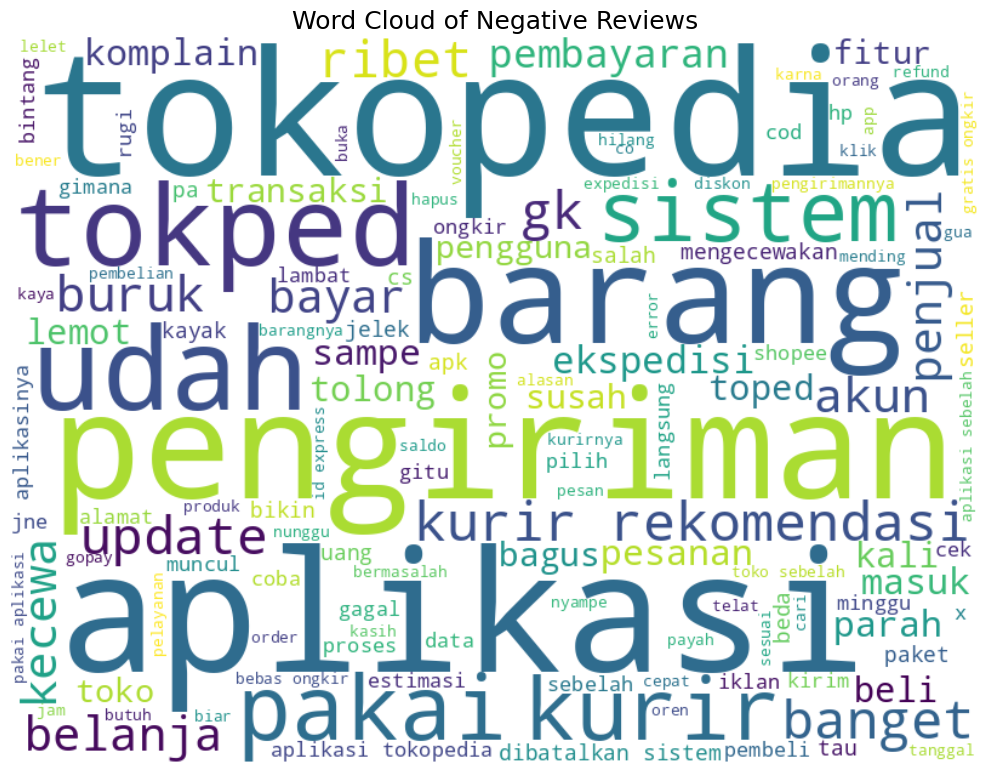

In [18]:
negative_tweets = df[df['polarity'] == 'negative']
negative_tweets = negative_tweets[['text_akhir', 'polarity_score', 'polarity','text_stopword']]
negative_tweets = negative_tweets.sort_values(by='polarity_score', ascending=False)
negative_tweets = negative_tweets.reset_index(drop=True)

list_words_negative = ' '.join(negative_tweets['text_stopword'].apply(lambda x: ' '.join(x)))
wordcloud_negative = WordCloud(width=800, height=600, background_color='white', min_font_size=10).generate(list_words_negative)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Word Cloud of Negative Reviews', fontsize=18)
plt.axis('off')
plt.tight_layout()

plt.show()

## **Ekstraksi Fitur**

pisahkan label dan fitur

In [20]:
X = df['text_akhir']
y = df['polarity']

ekstraksi fiture menggunakan tf-idf dari Sklearn

In [21]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

cek label

In [54]:
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Mapping Label:", label_mapping)

Mapping Label: {'negative': 0, 'neutral': 1, 'positive': 2}


Ubah hasil ekstraksi kedalam bentuk Dataframe

Lakukan split set dimana 8:2

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

Implementasi tfidf untuk ekstraksi fitur

In [23]:
tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word',
                        stop_words=None, ngram_range=(1, 3), smooth_idf=True)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

masukan hasil ekstraksi fitur sebelumnya kedalam feat_df dengan bentuk vektor

In [24]:
feat_df = pd.DataFrame(X_train_tfidf.toarray(), columns=tfidf.get_feature_names_out())

## **Modeling**

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# **Machine learning Model**

Support Vector Machines

In [26]:
svm_model = SVC(kernel='linear', C=1.0, random_state=42)

svm_model.fit(X_train_tfidf, y_train)

y_pred_train_svm = svm_model.predict(X_train_tfidf)
y_pred_test_svm = svm_model.predict(X_test_tfidf)

accuracy_train_svm = accuracy_score(y_train, y_pred_train_svm)
accuracy_test_svm = accuracy_score(y_test, y_pred_test_svm)

print("SVM with TF-IDF - accuracy_train:", accuracy_train_svm)
print("SVM with TF-IDF - accuracy_test:", accuracy_test_svm)

SVM with TF-IDF - accuracy_train: 0.8946782178217821
SVM with TF-IDF - accuracy_test: 0.8618811881188119


Neural Network

In [35]:
mlp_model = MLPClassifier(hidden_layer_sizes=(100), activation='relu', solver='adam', alpha=0.01, max_iter=1000)

mlp_model.fit(X_train_tfidf, y_train)

y_pred_train_mlp = mlp_model.predict(X_train_tfidf)
y_pred_test_mlp = mlp_model.predict(X_test_tfidf)

accuracy_train_mlp = accuracy_score(y_train, y_pred_train_mlp)
accuracy_test_mlp = accuracy_score(y_test, y_pred_test_mlp)

print("MLP with TF-IDF - accuracy_train:", accuracy_train_mlp)
print("MLP with TF-IDF - accuracy_test:", accuracy_test_mlp)

MLP with TF-IDF - accuracy_train: 0.9995049504950495
MLP with TF-IDF - accuracy_test: 0.8539603960396039


Logistic Regresion

In [28]:
logreg_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

logreg_model.fit(X_train_tfidf, y_train)

y_pred_train_logreg = logreg_model.predict(X_train_tfidf)
y_pred_test_logreg = logreg_model.predict(X_test_tfidf)

accuracy_train_logreg = accuracy_score(y_train, y_pred_train_logreg)
accuracy_test_logreg = accuracy_score(y_test, y_pred_test_logreg)

print("Logistic Regression with TF-IDF - accuracy_train:", accuracy_train_logreg)
print("Logistic Regression with TF-IDF - accuracy_test:", accuracy_test_logreg)

Logistic Regression with TF-IDF - accuracy_train: 0.8917079207920792
Logistic Regression with TF-IDF - accuracy_test: 0.8633663366336634


Menggunakan algoritma deep learning di luar dari contoh latihan.

Implementasikan Callback

In [29]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('val_accuracy') >= 0.85 and logs.get('accuracy') >= 0.9):
            print("\nPelatihan harus dihentikan karena Sudah mencapai target yang diinginkan")
            self.model.stop_training = True

callbacks = myCallback()

Buat model

In [30]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, input_shape=(X_train_tfidf.shape[1],), activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(3, activation='softmax')
])

Compile Model

In [31]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Latih Model

In [32]:
history = model.fit(X_train_tfidf.toarray(),
                    y_train, epochs=20, batch_size=32,
                    validation_data=(X_test_tfidf.toarray(), y_test),
                    callbacks=[callbacks])

Epoch 1/20
253/253 [==============================] - 3s 6ms/step - loss: 0.6312 - accuracy: 0.7347 - val_loss: 0.4154 - val_accuracy: 0.8505
Epoch 2/20
253/253 [==============================] - 2s 7ms/step - loss: 0.3717 - accuracy: 0.8671 - val_loss: 0.3815 - val_accuracy: 0.8594
Epoch 3/20
253/253 [==============================] - 2s 9ms/step - loss: 0.3060 - accuracy: 0.8901 - val_loss: 0.3768 - val_accuracy: 0.8644
Epoch 4/20
244/253 [===========================>..] - ETA: 0s - loss: 0.2489 - accuracy: 0.9088
Pelatihan harus dihentikan karena Sudah mencapai target yang diinginkan
253/253 [==============================] - 1s 5ms/step - loss: 0.2508 - accuracy: 0.9084 - val_loss: 0.3843 - val_accuracy: 0.8658
